<a href="https://colab.research.google.com/github/BondaiKa/Car-Model-Classification/blob/master/MainWorker.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [39]:
import pandas as pd
from datetime import datetime
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import os 
import tensorflow_addons as tfa
import tensorflow_addons as tfma

%matplotlib inline
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [6]:
print(tf.config.list_physical_devices("GPU"))
print(tf.config.list_logical_devices("CPU"))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
[LogicalDevice(name='/device:CPU:0', device_type='CPU')]


In [7]:
DATASET_DIR = "./GRZ_and_model_recognition/test"
NUM_CLASSES = 11
BATCH_SIZE = 256

In [8]:

data_dir = os.listdir(DATASET_DIR+'/train')
data_dir

['KAMAZ_ALLKAMAZ_C',
 'LADA_PRIORA_B',
 'MAZDA_3_B',
 'RЕNАULТ_DUSТЕR_B',
 'SCANIA_ALLSCANIA_C',
 'TOYOTA_RАV4_B',
 'VOLVO_ALLVOLVO_C',
 'VОLКSWАGЕN_TIGUAN_B',
 'VОLКSWАGЕN_РОLО_B',
 'КIА_RIО_B',
 'НУUNDАI_SОLАRIS_B']

In [9]:
TRAIN_PATH = DATASET_DIR + '/train'
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  TRAIN_PATH,
  batch_size = BATCH_SIZE
)

Found 176 files belonging to 11 classes.


In [10]:
class_names = train_ds.class_names
class_names

['KAMAZ_ALLKAMAZ_C',
 'LADA_PRIORA_B',
 'MAZDA_3_B',
 'RЕNАULТ_DUSТЕR_B',
 'SCANIA_ALLSCANIA_C',
 'TOYOTA_RАV4_B',
 'VOLVO_ALLVOLVO_C',
 'VОLКSWАGЕN_TIGUAN_B',
 'VОLКSWАGЕN_РОLО_B',
 'КIА_RIО_B',
 'НУUNDАI_SОLАRIS_B']

In [11]:
VAL_PATH = DATASET_DIR + '/val'
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  VAL_PATH,
  batch_size = BATCH_SIZE
)

Found 176 files belonging to 11 classes.


(256, 256, 3)


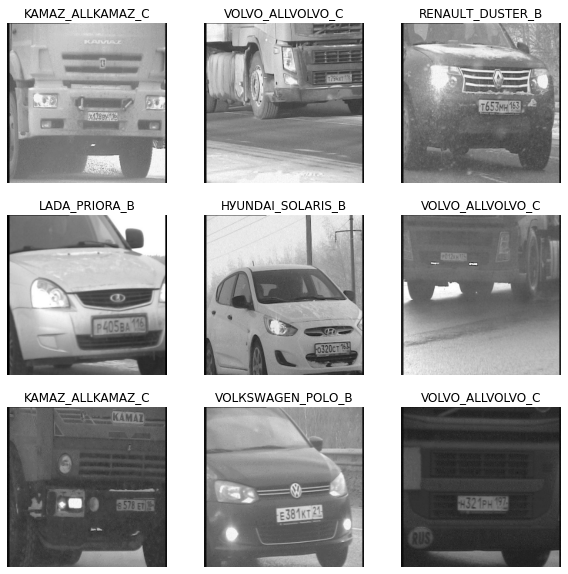

In [12]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    print(images[0].shape)
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [13]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(176, 256, 256, 3)
(176,)


In [14]:
logdir = "logs/test-pipeline"
checkpoint_path = "models/test/training__{epoch:02d}__{loss:.6f}/cp.ckpt"


tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
early_stop_callback = tf.keras.callbacks.EarlyStopping(patience=7,monitor='val_loss')
reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', factor=0.5, patience=5, verbose=1, mode='auto',
    min_delta=0.0001, cooldown=0, min_lr=0
)

In [34]:
alex_model = tf.keras.models.Sequential([
    # 1st conv
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(256, 256, 3)),
  tf.keras.layers.Conv2D(96, (11,11),strides=(4,4), activation='relu'),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2,2)),
    # 2nd conv
  tf.keras.layers.Conv2D(256, (11,11),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
     # 3rd conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 4th conv
  tf.keras.layers.Conv2D(384, (3,3),strides=(1,1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
    # 5th Conv
  tf.keras.layers.Conv2D(256, (3, 3), strides=(1, 1), activation='relu',padding="same"),
  tf.keras.layers.BatchNormalization(),
  tf.keras.layers.MaxPooling2D(2, strides=(2, 2)),
    # To Flatten layer
  tf.keras.layers.Flatten(),
    # To FC layer 1
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
    #To FC layer 2
  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.5),
  tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [41]:
from tensorflow.keras import backend as K

def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall_keras = true_positives / (possible_positives + K.epsilon())
    return recall_keras


def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision_keras = true_positives / (predicted_positives + K.epsilon())
    return precision_keras

def f1(y_true, y_pred):
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return 2 * ((p * r) / (p + r + K.epsilon()))


In [42]:
alex_model.compile(
    optimizer=tf.optimizers.SGD(lr=0.001),
    loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy',f1]
)
alex_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling_2 (Rescaling)      (None, 256, 256, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 62, 96)        34944     
_________________________________________________________________
batch_normalization_10 (Batc (None, 62, 62, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 96)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 31, 31, 256)       2973952   
_________________________________________________________________
batch_normalization_11 (Batc (None, 31, 31, 256)       1024      
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 31, 31, 384)      

In [43]:
with tf.device('/device:GPU:0'):
    alex_model.fit(
        train_ds,
        validation_data=val_ds,
        epochs=100,
        callbacks=[
            tensorboard_callback, 
            cp_callback, 
            early_stop_callback, 
            reduce_lr_callback
        ],
)

Epoch 1/100
1/1 [==============================] - ETA: 0s - loss: 2.4159 - accuracy: 0.1023 - f1: 2.5000
Epoch 00001: saving model to models/test/training__01__2.415916\cp.ckpt
1/1 [==============================] - 4s 4s/step - loss: 2.4159 - accuracy: 0.1023 - f1: 2.5000 - val_loss: 2.3979 - val_accuracy: 0.1136 - val_f1: 11.0000
Epoch 2/100
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1/1 [==============================] - ETA: 0s - loss: 2.4150 - accuracy: 0.0966 - f1: 2.6115
Epoch 00002: saving model to models/test/training__02__2.415021\cp.ckpt
1/1 [==============================] - 2s 2s/step - loss: 2.4150 - accuracy: 0.0966 - f1: 2.6115 - val_loss: 2.3979 - val_accuracy: 0.1250 - val_f1: 11.0000
Epoch 3/100
1/1 [==============================] - ETA: 0s - loss: 2.4180 - accuracy: 0.0966 - f1: 2.7286
Epoch 00003: saving model to models/test/training__03__2.418023\cp.ckpt
1/1 [==============================] - 2s 2s/step - loss: 2.4180 - accuracy: 0.0

In [22]:
%tensorboard --logdir logs/

Launching TensorBoard...

KeyboardInterrupt: 